<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle
import bs4 as bs
import urllib
import re
#
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

### Datos
Utilizaremos como dataset libros del site gutember.org en el idioma inglés.

In [2]:
pages = [
    # "https://www.gutenberg.org/cache/epub/70828/pg70828-images.html",
    # 'https://www.gutenberg.org/cache/epub/70829/pg70829-images.html',
    # "https://www.gutenberg.org/cache/epub/70827/pg70827-images.html",
    # "https://www.gutenberg.org/cache/epub/70826/pg70826-images.html",
    # "https://www.gutenberg.org/cache/epub/70824/pg70824-images.html",
    # "https://www.gutenberg.org/cache/epub/70823/pg70823-images.html",
    "https://www.gutenberg.org/cache/epub/70822/pg70822-images.html",
    "https://www.gutenberg.org/cache/epub/70820/pg70820-images.html"
]

In [3]:
def get_page_text(url):
    raw_html = urllib.request.urlopen(url)
    raw_html = raw_html.read()

    article_html = bs.BeautifulSoup(raw_html, 'lxml')

    article_paragraphs = article_html.find_all('p', attrs={"class": None})

    text = []

    for p in article_paragraphs:
        if len(p.text) > 100:
            text.append(p.text)

    return text


In [4]:
text = []

for page in pages:
    content = get_page_text(page)
    print(len(content))
    text += content

len(text)

677
1877


2554

### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding
#from keras_preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [7]:
# Ejemplo de como transformar una oración a tokens usando keras
text[0]

'Credits: Sonya Schermann, Debrah Thompson and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by The Internet Archive)'

In [8]:
tokens = text_to_word_sequence(text[0]) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['credits',
 'sonya',
 'schermann',
 'debrah',
 'thompson',
 'and',
 'the',
 'online',
 'distributed',
 'proofreading',
 'team',
 'at',
 'https',
 'www',
 'pgdp',
 'net',
 'this',
 'file',
 'was',
 'produced',
 'from',
 'images',
 'generously',
 'made',
 'available',
 'by',
 'the',
 'internet',
 'archive']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [9]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for row in text:
    sentence_tokens.append(text_to_word_sequence(row))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['credits',
  'sonya',
  'schermann',
  'debrah',
  'thompson',
  'and',
  'the',
  'online',
  'distributed',
  'proofreading',
  'team',
  'at',
  'https',
  'www',
  'pgdp',
  'net',
  'this',
  'file',
  'was',
  'produced',
  'from',
  'images',
  'generously',
  'made',
  'available',
  'by',
  'the',
  'internet',
  'archive'],
 ['so',
  'swiftly',
  'did',
  'one',
  'incident',
  'of',
  'change',
  'crowd',
  'upon',
  'another',
  'at',
  'this\r',
  'period',
  'of',
  'the',
  'lives',
  'which',
  'we',
  'fear',
  'we',
  'are',
  'but',
  'faintly',
  'sketching',
  'that\r',
  'it',
  'seemed',
  'as',
  'if',
  'fortune',
  'had',
  'arranged',
  'all',
  'the',
  'concomitant',
  'circumstances\r',
  'that',
  'were',
  'culminating',
  'in',
  'these',
  'few',
  'eventful',
  'days',
  'of',
  'autumn']]

In [11]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['credits', 'sonya', 'schermann', 'debrah'],
 ['sonya', 'schermann', 'debrah', 'thompson'],
 ['schermann', 'debrah', 'thompson', 'and'],
 ['debrah', 'thompson', 'and', 'the'],
 ['thompson', 'and', 'the', 'online'],
 ['and', 'the', 'online', 'distributed'],
 ['the', 'online', 'distributed', 'proofreading'],
 ['online', 'distributed', 'proofreading', 'team'],
 ['distributed', 'proofreading', 'team', 'at'],
 ['proofreading', 'team', 'at', 'https'],
 ['team', 'at', 'https', 'www'],
 ['at', 'https', 'www', 'pgdp'],
 ['https', 'www', 'pgdp', 'net'],
 ['www', 'pgdp', 'net', 'this'],
 ['pgdp', 'net', 'this', 'file'],
 ['net', 'this', 'file', 'was'],
 ['this', 'file', 'was', 'produced'],
 ['file', 'was', 'produced', 'from'],
 ['was', 'produced', 'from', 'images'],
 ['produced', 'from', 'images', 'generously'],
 ['from', 'images', 'generously', 'made'],
 ['images', 'generously', 'made', 'available'],
 ['generously', 'made', 'available', 'by'],
 ['made', 'available', 'by', 'the'],
 ['available',

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [13]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [14]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[26, 25, 23, 2],
 [25, 23, 2, 3],
 [23, 2, 3, 4],
 [2, 3, 4, 1],
 [3, 4, 1, 5],
 [4, 1, 5, 6],
 [1, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 10],
 [8, 9, 10, 11],
 [9, 10, 11, 12],
 [10, 11, 12, 13],
 [11, 12, 13, 14],
 [12, 13, 14, 15],
 [13, 14, 15, 16],
 [14, 15, 16, 17],
 [15, 16, 17, 18],
 [16, 17, 18, 19],
 [17, 18, 19, 20],
 [18, 19, 20, 21],
 [19, 20, 21, 22],
 [20, 21, 22, 24],
 [21, 22, 24, 1],
 [22, 24, 1, 27]]

In [15]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

25


In [16]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

27


In [17]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'debrah': 2, 'thompson': 3, 'and': 4, 'online': 5, 'distributed': 6, 'proofreading': 7, 'team': 8, 'at': 9, 'https': 10, 'www': 11, 'pgdp': 12, 'net': 13, 'this': 14, 'file': 15, 'was': 16, 'produced': 17, 'from': 18, 'images': 19, 'generously': 20, 'made': 21, 'available': 22, 'schermann': 23, 'by': 24, 'sonya': 25, 'credits': 26, 'internet': 27}


In [18]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'schermann': 3, 'credits': 1, 'debrah': 4, 'sonya': 2, 'thompson': 4, 'and': 4, 'the': 6, 'online': 4, 'distributed': 4, 'proofreading': 4, 'team': 4, 'at': 4, 'https': 4, 'www': 4, 'pgdp': 4, 'net': 4, 'this': 4, 'file': 4, 'was': 4, 'produced': 4, 'from': 4, 'images': 4, 'generously': 4, 'made': 4, 'available': 4, 'by': 3, 'internet': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [19]:
# Vistazo a las primeras filas
text[:15]

['Credits: Sonya Schermann, Debrah Thompson and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by The Internet Archive)',
 'So swiftly did one incident of change crowd upon another at this\r\nperiod of the lives which we fear we are but faintly sketching, that\r\nit seemed as if Fortune had arranged all the concomitant circumstances\r\nthat were culminating in these few eventful days of autumn.',
 'Fortune, “the great commandress of the world,” had already played\r\nstrange pranks with those two charming girls at Barton. Until lately\r\ntheir destinies had flowed on smoothly and in peace. They had grown up\r\nside by side,—one the[Pg 2]\r\nmistress, the other the companion and friend,—and until now there had\r\nbeen no jealousy on either hand—until now Amy Somerton had been content\r\nwith her lot. She had brooded over her lowly birth,\r\nin those hours when she had loved and dreamed about her love for Mr.\

In [20]:
len(text)

2554

In [21]:
# Concatenamos todos los rows en un solo valor
corpus = ''.join(text)
corpus

'Credits: Sonya Schermann, Debrah Thompson and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by The Internet Archive)So swiftly did one incident of change crowd upon another at this\r\nperiod of the lives which we fear we are but faintly sketching, that\r\nit seemed as if Fortune had arranged all the concomitant circumstances\r\nthat were culminating in these few eventful days of autumn.Fortune, “the great commandress of the world,” had already played\r\nstrange pranks with those two charming girls at Barton. Until lately\r\ntheir destinies had flowed on smoothly and in peace. They had grown up\r\nside by side,—one the[Pg 2]\r\nmistress, the other the companion and friend,—and until now there had\r\nbeen no jealousy on either hand—until now Amy Somerton had been content\r\nwith her lot. She had brooded over her lowly birth,\r\nin those hours when she had loved and dreamed about her love for Mr.\r\nHammerto

In [22]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['credits',
 'sonya',
 'schermann',
 'debrah',
 'thompson',
 'and',
 'the',
 'online',
 'distributed',
 'proofreading',
 'team',
 'at',
 'https',
 'www',
 'pgdp',
 'net',
 'this',
 'file',
 'was',
 'produced']

In [23]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 139555


In [24]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [25]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['credits', 'sonya', 'schermann', 'debrah'],
 ['sonya', 'schermann', 'debrah', 'thompson'],
 ['schermann', 'debrah', 'thompson', 'and'],
 ['debrah', 'thompson', 'and', 'the'],
 ['thompson', 'and', 'the', 'online'],
 ['and', 'the', 'online', 'distributed'],
 ['the', 'online', 'distributed', 'proofreading'],
 ['online', 'distributed', 'proofreading', 'team'],
 ['distributed', 'proofreading', 'team', 'at'],
 ['proofreading', 'team', 'at', 'https'],
 ['team', 'at', 'https', 'www'],
 ['at', 'https', 'www', 'pgdp'],
 ['https', 'www', 'pgdp', 'net'],
 ['www', 'pgdp', 'net', 'this'],
 ['pgdp', 'net', 'this', 'file'],
 ['net', 'this', 'file', 'was'],
 ['this', 'file', 'was', 'produced'],
 ['file', 'was', 'produced', 'from'],
 ['was', 'produced', 'from', 'images'],
 ['produced', 'from', 'images', 'generously']]

In [26]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[13607, 13606, 13605, 6863],
 [13606, 13605, 6863, 6864],
 [13605, 6863, 6864, 2],
 [6863, 6864, 2, 1],
 [6864, 2, 1, 6865],
 [2, 1, 6865, 3598],
 [1, 6865, 3598, 6866],
 [6865, 3598, 6866, 6867],
 [3598, 6866, 6867, 16],
 [6866, 6867, 16, 6868],
 [6867, 16, 6868, 6869],
 [16, 6868, 6869, 6870],
 [6868, 6869, 6870, 6871],
 [6869, 6870, 6871, 46],
 [6870, 6871, 46, 2484],
 [6871, 46, 2484, 7],
 [46, 2484, 7, 1732],
 [2484, 7, 1732, 37],
 [7, 1732, 37, 6872],
 [1732, 37, 6872, 4649]]

In [27]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 139551


### 3 - Input y target

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [29]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [30]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [31]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(139551, 3)
(139551,)


In [32]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'of',
 4: 'to',
 5: 'a',
 6: 'in',
 7: 'was',
 8: 'he',
 9: 'his',
 10: 'had',
 11: 'with',
 12: 'that',
 13: '\r',
 14: 'on',
 15: 'it',
 16: 'at',
 17: 'they',
 18: 'jack',
 19: 'for',
 20: 'were',
 21: 'the\r',
 22: 'you',
 23: 'i',
 24: 'him',
 25: 'as',
 26: 'her',
 27: '’',
 28: 'but',
 29: 'said',
 30: 'not',
 31: 'their',
 32: 'by',
 33: 'which',
 34: 'be',
 35: 'up',
 36: 'all',
 37: 'from',
 38: 'she',
 39: 'who',
 40: 'have',
 41: 'them',
 42: 'then',
 43: 'been',
 44: 'when',
 45: 'and\r',
 46: 'this',
 47: 'one',
 48: 'out',
 49: 'would',
 50: 'is',
 51: 'so',
 52: 'will',
 53: 'an',
 54: 'there',
 55: 'some',
 56: 'of\r',
 57: 'men',
 58: 'no',
 59: 'a\r',
 60: 'me',
 61: 'or',
 62: 'down',
 63: 'about',
 64: 'could',
 65: 'to\r',
 66: 'my',
 67: 'upon',
 68: 'we',
 69: 'two',
 70: 'into',
 71: 'your',
 72: 'more',
 73: '”',
 74: 'what',
 75: 'came',
 76: 'if',
 77: 'before',
 78: 'time',
 79: 'made',
 80: 'day',
 81: 'are',
 82: 'over',
 83: 'ru

In [33]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

13607

In [34]:
# Transformar los datos a oneHotEncoding
#y_data = to_categorical(y_data_int, num_classes=vocab_size)
y_data = to_categorical(y_data_int)

In [35]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [36]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(139551, 13607)

### 4 - Entrenar el modelo

In [37]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [38]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

13607

In [39]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
#model.add(Dense(32, activation='relu'))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              68040     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           137216    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 dense (Dense)               (None, 3, 32)             8224      
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [40]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
3489/3489 [==============================] - 71s 17ms/step - loss: 7.1724 - accuracy: 0.0564 - val_loss: 7.0316 - val_accuracy: 0.0619
Epoch 2/50
3489/3489 [==============================] - 51s 15ms/step - loss: 6.9990 - accuracy: 0.0636 - val_loss: 6.9023 - val_accuracy: 0.0708
Epoch 3/50
3489/3489 [==============================] - 54s 16ms/step - loss: 6.9013 - accuracy: 0.0692 - val_loss: 6.8551 - val_accuracy: 0.0734
Epoch 4/50
3489/3489 [==============================] - 55s 16ms/step - loss: 6.8447 - accuracy: 0.0754 - val_loss: 6.8706 - val_accuracy: 0.0866
Epoch 5/50
3489/3489 [==============================] - 50s 14ms/step - loss: 6.7912 - accuracy: 0.0841 - val_loss: 6.7739 - val_accuracy: 0.0865
Epoch 6/50
3489/3489 [==============================] - 54s 15ms/step - loss: 6.7594 - accuracy: 0.0897 - val_loss: 6.7891 - val_accuracy: 0.0932
Epoch 7/50
3489/3489 [==============================] - 50s 14ms/step - loss: 6.7392 - accuracy: 0.0925 - val_loss: 6.7513 -

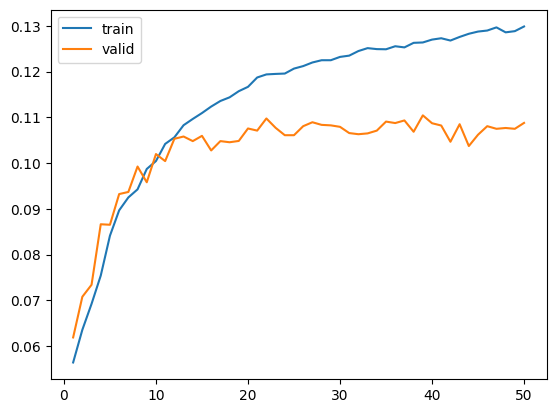

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [42]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [43]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:0

In [44]:
!pip3 install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-45-2a8fe09160a6>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [48]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [49]:
input_text='There is'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 31ms/step


'There is to which'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.